In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0627 16:15:53.317627 4560143808 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Fashion MNIST Data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

In [4]:
y_train.shape

(60000,)

# Cross-Entropy

In [5]:
#One hot the labels
num_classes = 10
y_train_oh = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train_oh.shape

(60000, 10)

In [7]:
max_val = 1.0
y_train_oh = y_train_oh * max_val
remainder = (1 - max_val)/9.0

In [8]:
remainder

0.0

In [9]:
to_add = np.ones(y_train_oh.shape)
for i in range(len(y_train_oh)):
    correct_index = y_train[i]
    to_add[i, correct_index] = 0
to_add = to_add * remainder
y_train_oh = y_train_oh + to_add

In [10]:
x_train_master, y_train_master = x_train[:30000], y_train_oh[:30000]
x_train_slave, y_train_slave = x_train[30000:], y_train_oh[30000:]

In [11]:
#Flatten everything
x_train_master_flat, input_shape = flatten_mnist(x_train_master) 
x_train_slave_flat, _ = flatten_mnist(x_train_slave)
x_test_flat, _  = flatten_mnist(x_test)

In [12]:
#Configurations
eps_train = 0.1                                                                                                                            
eps_test = 0.1                                                                                                                             
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"                                                                                                               
load_weights = False                                                                                                              
load_counter = 234                                                                                                            
sigma = tf.nn.relu                                                                                                                         
epochs, reg, lr = 10, 0.00, 1e-3    
#epochs, reg, lr = 30, 0.00, 15e-4                                                                                                          
pgd_eta, pgd_num_iter = 1e-2, 50

In [14]:
input_shape

(784,)

In [13]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 32]
dataset = ((x_train_master_flat, y_train_master), (x_test_flat, y_test))

scope_name = "teacher_student_fashion"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        model.fit(sess, x_train_master_flat, y_train_master, training_epochs = epochs, reg_op = reg , lr = lr)
        cross_margins = model.get_pointwise_margin(sess, x_train_master_flat, y_train)

        """
        #Save weights
        weights = tf.trainable_variables()
        #weights = model.get_weights()[0] + model.get_weights()[1]
        saver = tf.train.Saver(weights)
        weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
        print("Saved model at %s"%weights_path)
        """
        
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv
        cross_loss, cross_acc = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((cross_loss, cross_acc))
        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)

Initialized instance variables of the robust model class
I0627 16:15:55.243912 4560143808 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0627 16:15:55.245617 4560143808 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0627 16:15:55.269140 4560143808 feedforward_robust.py:40] Created placeholders for x and y
W0627 16:15:55.271883 4560143808 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0627 16:15:55.272794 4560143808 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0627 16:15:55.274067 4560143808 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0627 16:15:56.596240 4560143808 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.605939807 
I0627 16:15:58.670604 4560143808 feedforward_robust.py:732] Epoch: 0001    cost: 0.605939807 
Accuracy on batch: 0.781250
I0627 16:15:58.674954 4560143808 feedforward_robust.py:733] Accuracy on batch: 0.781250
Epoch: 0002    cost: 0.422434728 
I0627 16:15:59.630665 4560143808 feedforward_robust.py:732] Epoch: 0002    cost: 0.422434728 
Accuracy on batch: 0.812500
I0627 16:15:59.632710 4560143808 feedforward_robust.py:733] Accuracy on batch: 0.812500
Epoch: 0003    cost: 0.376853539 
I0627 16:16:01.050021 4560143808 feedforward_robust.py:732] Epoch: 0003    cost: 0.376853539 
Accuracy on batch: 0.812500
I0627 16:16:01.051379 4560143808 fe

----- Weight norms ----
[27.308752, 11.164049, 8.699152, 6.271835]
----Regular test accuracy and loss ----
(0.40496257, 0.8605)


(array([ 1086.,  1036.,  1050.,   963.,  1096.,  1180.,  1319.,  1534.,
         2138., 18598.]),
 array([1.4612079e-04, 1.0013151e-01, 2.0011690e-01, 3.0010229e-01,
        4.0008768e-01, 5.0007308e-01, 6.0005844e-01, 7.0004386e-01,
        8.0002922e-01, 9.0001464e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

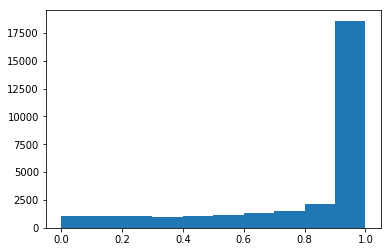

In [14]:
plt.hist(cross_margins, 10)

# MSE

In [15]:
# Cross-Entropy
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

#One hot the labels
num_classes = 10
y_train_oh = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train_oh.shape

max_val = 1.0
y_train_oh = y_train_oh * max_val
remainder = (1 - max_val)/9.0

remainder

to_add = np.ones(y_train_oh.shape)

for i in range(len(y_train_oh)):
    correct_index = y_train[i]
    to_add[i, correct_index] = 0
to_add = to_add * remainder
y_train_oh = y_train_oh + to_add

x_train_master, y_train_master = x_train[:30000], y_train_oh[:30000]
x_train_slave, y_train_slave = x_train[30000:], y_train_oh[30000:]

#Flatten everything
x_train_master_flat, input_shape = flatten_mnist(x_train_master) 
x_train_slave_flat, _ = flatten_mnist(x_train_slave)
x_test_flat, _  = flatten_mnist(x_test)


#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 32]
dataset = ((x_train_master_flat, y_train_master), (x_test_flat, y_test))

scope_name = "teacher_student_fashion"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma, classification = False)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        model.fit(sess, x_train_master_flat, y_train_master, training_epochs = epochs, reg_op = reg , lr = lr)
        mse_margins = model.get_pointwise_margin(sess, x_train_master_flat, y_train)

        """
        #Save weights
        weights = tf.trainable_variables()
        #weights = model.get_weights()[0] + model.get_weights()[1]
        saver = tf.train.Saver(weights)
        weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
        print("Saved model at %s"%weights_path)
        """
        
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv
        cross_loss, cross_acc = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((cross_loss, cross_acc))
        
        mse_confidences = model.get_prediction(sess, x_test_flat)



Initialized instance variables of the robust model class
I0615 22:46:20.050969 4532680128 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0615 22:46:20.058298 4532680128 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0615 22:46:20.144038 4532680128 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0615 22:46:20.151237 4532680128 feedforward_robust.py:48] Added accuracy computation to the graph
Added MSE loss computation to the graph
I0615 22:46:20.161925 4532680128 feedforward_robust.py:60] Added MSE loss computation to the graph
Model graph was created
I0615 22:46:20.163429 4532680128 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.093834685 
I0615 22:46:21.702965 4532680128 feedforward_robust.py:732] Epoch: 0001    cost: 0.093834685 
Accuracy on batch: 0.843750
I0615 22:46:21.705790 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0002    cost: 0.060781464 
I0615 22:46:22.576101 4532680128 feedforward_robust.py:732] Epoch: 0002    cost: 0.060781464 
Accuracy on batch: 0.843750
I0615 22:46:22.577420 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0003    cost: 0.053727703 
I0615 22:46:23.455960 4532680128 feedforward_robust.py:732] Epoch: 0003    cost: 0.053727703 
Accuracy on batch: 0.843750
I0615 22:46:23.457340 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0004    cost: 0.049619814 
I0615 22:46:24.333343 4532680128 feedforward_robust.py:732] Epoch: 0004    cost: 0.049619814 
Accuracy on batch: 0.843750
I0615 22:46:24.334620 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0005    cost: 0.0

----- Weight norms ----
[22.34508, 9.538677, 8.302387, 3.509004]
----Regular test accuracy and loss ----
(0.054219052, 0.8551)


(array([2.0620e+03, 1.9430e+03, 2.0870e+03, 2.6270e+03, 5.2270e+03,
        1.4083e+04, 1.8580e+03, 9.3000e+01, 1.7000e+01, 3.0000e+00]),
 array([4.2766333e-06, 2.6090767e-02, 5.2177258e-02, 7.8263745e-02,
        1.0435024e-01, 1.3043672e-01, 1.5652321e-01, 1.8260971e-01,
        2.0869620e-01, 2.3478268e-01, 2.6086918e-01], dtype=float32),
 <a list of 10 Patch objects>)

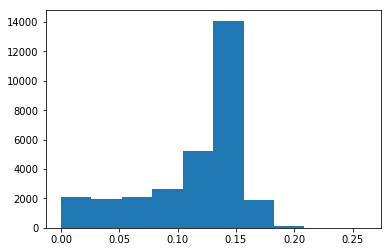

In [16]:
plt.hist(mse_margins, 10)

# Max val 0.8

Initialized instance variables of the robust model class
I0615 22:46:31.064414 4532680128 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0615 22:46:31.071211 4532680128 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0615 22:46:31.158025 4532680128 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0615 22:46:31.166885 4532680128 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0615 22:46:31.207326 4532680128 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0615 22:46:31.212543 4532680128 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 1.338952615 
I0615 22:46:32.942646 4532680128 feedforward_robust.py:732] Epoch: 0001    cost: 1.338952615 
Accuracy on batch: 0.812500
I0615 22:46:32.943882 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.812500
Epoch: 0002    cost: 1.211620381 
I0615 22:46:33.950860 4532680128 feedforward_robust.py:732] Epoch: 0002    cost: 1.211620381 
Accuracy on batch: 0.843750
I0615 22:46:33.952459 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0003    cost: 1.178260050 
I0615 22:46:35.187599 4532680128 feedforward_robust.py:732] Epoch: 0003    cost: 1.178260050 
Accuracy on batch: 0.843750
I0615 22:46:35.189363 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0004    cost: 1.158024806 
I0615 22:46:36.184636 4532680128 feedforward_robust.py:732] Epoch: 0004    cost: 1.158024806 
Accuracy on batch: 0.875000
I0615 22:46:36.186162 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.875000
Epoch: 0005    cost: 1.1

----- Weight norms ----
[25.9286, 10.969687, 9.3189, 5.06056]
----Regular test accuracy and loss ----
(0.054219052, 0.8551)


(array([ 1242.,  1181.,  1176.,  1192.,  1230.,  1653.,  2640.,  8684.,
        10668.,   334.]),
 array([1.3768673e-05, 9.5336691e-02, 1.9065961e-01, 2.8598252e-01,
        3.8130546e-01, 4.7662836e-01, 5.7195127e-01, 6.6727418e-01,
        7.6259714e-01, 8.5792005e-01, 9.5324296e-01], dtype=float32),
 <a list of 10 Patch objects>)

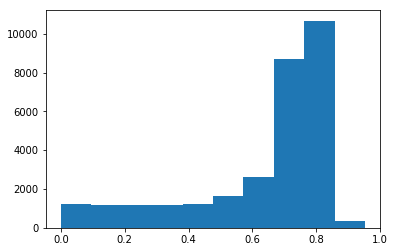

In [17]:
# Cross-Entropy
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

#One hot the labels
num_classes = 10
y_train_oh = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train_oh.shape

max_val = 0.8
y_train_oh = y_train_oh * max_val
remainder = (1 - max_val)/9.0

remainder

to_add = np.ones(y_train_oh.shape)
for i in range(len(y_train_oh)):
    correct_index = y_train[i]
    to_add[i, correct_index] = 0
to_add = to_add * remainder
y_train_oh = y_train_oh + to_add

y_train = y_train_oh

x_train_master, y_train_master = x_train[:30000], y_train_oh[:30000]
x_train_slave, y_train_slave = x_train[30000:], y_train_oh[30000:]

#Flatten everything
x_train_master_flat, input_shape = flatten_mnist(x_train_master) 
x_train_slave_flat, _ = flatten_mnist(x_train_slave)
x_test_flat, _  = flatten_mnist(x_test)

#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 32]
dataset = ((x_train_master_flat, y_train_master), (x_test_flat, y_test))

scope_name = "teacher_student_fashion"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        model.fit(sess, x_train_master_flat, y_train_master, training_epochs = epochs, reg_op = reg , lr = lr)
        eight_margins = model.get_pointwise_margin(sess, x_train_master_flat, y_train)

        """
        #Save weights
        weights = tf.trainable_variables()
        #weights = model.get_weights()[0] + model.get_weights()[1]
        saver = tf.train.Saver(weights)
        weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
        print("Saved model at %s"%weights_path)
        """
        
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv
        eight_loss, eight_acc = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((cross_loss, cross_acc))
        
        eight_confidences = model.get_prediction(sess, x_test_flat)
        eight_spectral = model.get_spectral_norm(sess)

plt.hist(eight_margins, 10)

# Max-val 0.5

Initialized instance variables of the robust model class
I0615 22:49:27.017462 4532680128 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0615 22:49:27.028186 4532680128 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0615 22:49:27.113569 4532680128 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0615 22:49:27.120342 4532680128 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0615 22:49:27.271380 4532680128 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0615 22:49:27.272515 4532680128 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 2.090274668 
I0615 22:49:28.843487 4532680128 feedforward_robust.py:732] Epoch: 0001    cost: 2.090274668 
Accuracy on batch: 0.843750
I0615 22:49:28.844671 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0002    cost: 2.059898032 
I0615 22:49:29.763029 4532680128 feedforward_robust.py:732] Epoch: 0002    cost: 2.059898032 
Accuracy on batch: 0.843750
I0615 22:49:29.764420 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0003    cost: 2.051608759 
I0615 22:49:30.653061 4532680128 feedforward_robust.py:732] Epoch: 0003    cost: 2.051608759 
Accuracy on batch: 0.843750
I0615 22:49:30.654187 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.843750
Epoch: 0004    cost: 2.046706144 
I0615 22:49:31.522540 4532680128 feedforward_robust.py:732] Epoch: 0004    cost: 2.046706144 
Accuracy on batch: 0.812500
I0615 22:49:31.523965 4532680128 feedforward_robust.py:733] Accuracy on batch: 0.812500
Epoch: 0005    cost: 2.0

----- Weight norms ----
[24.917799, 10.541225, 8.6786, 4.0297503]
----Regular test accuracy and loss ----
(1.1412097, 0.863)


(array([1.427e+03, 1.439e+03, 1.449e+03, 1.794e+03, 2.351e+03, 5.230e+03,
        1.497e+04, 1.254e+03, 7.800e+01, 8.000e+00]),
 array([8.4042549e-06, 5.1910210e-02, 1.0381202e-01, 1.5571383e-01,
        2.0761563e-01, 2.5951743e-01, 3.1141925e-01, 3.6332104e-01,
        4.1522285e-01, 4.6712464e-01, 5.1902646e-01], dtype=float32),
 <a list of 10 Patch objects>)

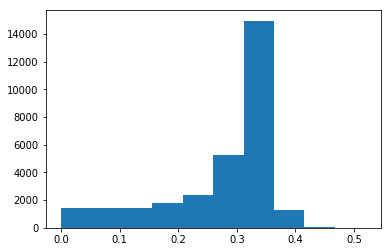

In [24]:
# Cross-Entropy
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

#One hot the labels
num_classes = 10
y_train_oh = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train_oh.shape

max_val = 0.4
y_train_oh = y_train_oh * max_val
remainder = (1 - max_val)/9.0

remainder

to_add = np.ones(y_train_oh.shape)
for i in range(len(y_train_oh)):
    correct_index = y_train[i]
    to_add[i, correct_index] = 0
to_add = to_add * remainder
y_train_oh = y_train_oh + to_add

y_train = y_train_oh

x_train_master, y_train_master = x_train[:30000], y_train_oh[:30000]
x_train_slave, y_train_slave = x_train[30000:], y_train_oh[30000:]

#Flatten everything
x_train_master_flat, input_shape = flatten_mnist(x_train_master) 
x_train_slave_flat, _ = flatten_mnist(x_train_slave)
x_test_flat, _  = flatten_mnist(x_test)

#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 32]
dataset = ((x_train_master_flat, y_train_master), (x_test_flat, y_test))

scope_name = "teacher_student_fashion"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        model.fit(sess, x_train_master_flat, y_train_master, training_epochs = epochs, reg_op = reg , lr = lr)
        five_margins = model.get_pointwise_margin(sess, x_train_master_flat, y_train)

        """
        #Save weights
        weights = tf.trainable_variables()
        #weights = model.get_weights()[0] + model.get_weights()[1]
        saver = tf.train.Saver(weights)
        weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
        print("Saved model at %s"%weights_path)
        """
        
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv
        five_loss, five_acc = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((five_loss, five_acc))
        
        five_confidences = model.get_prediction(sess, x_test_flat)
        five_spectral = model.get_spectral_norm(sess)

plt.hist(five_margins, 10)

In [25]:
import scipy

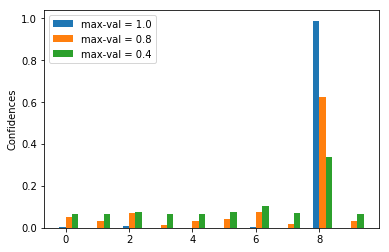

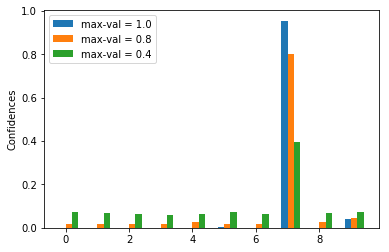

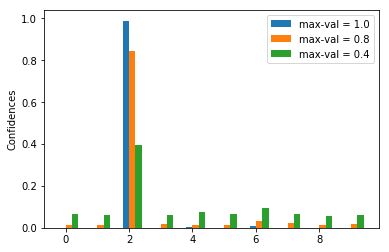

In [63]:
num_test = len(x_test)
idx_random = np.random.choice(num_test, 3)
for idx in idx_random:
    x = np.arange(10)
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - width/2, scipy.special.softmax(cross_confidences[idx]), width, label = 'max-val = 1.0')
    #ax.bar(x - 3*width/2, scipy.special.softmax(mse_confidences[idx]), width, label = 'mse')
    ax.bar(x + width/2, scipy.special.softmax(eight_confidences[idx]), width, label = 'max-val = 0.8')
    ax.bar(x + 3*width/2, scipy.special.softmax(five_confidences[idx]), width, label = 'max-val = 0.4')
    ax.set_ylabel('Confidences')
    ax.legend()
    plt.savefig("/Users/adhyyan/Desktop/confidence_" + str(idx), format = 'pdf')

In [31]:
cross_spectral

41428.88029991887

In [32]:
five_spectral

23761.932942290325

In [33]:
eight_spectral

33654.403441717965

In [37]:
df = pd.DataFrame()

In [38]:
cross_acc

0.8551

In [51]:
df['max val'] = [1.0, 0.8, 0.4]
df['test accuracy'] = [cross_acc, eight_acc, five_acc]
df['R_A'] = [cross_spectral, eight_spectral, five_spectral]

In [52]:
df = df.round(3)

In [53]:
df

,max val,test accuracy,R_A
0,1.0,0.855,41428.880
1,0.8,0.866,33654.403
2,0.4,0.863,23761.933


In [54]:
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  max val &  test accuracy &        R\_A \\
\midrule
0 &      1.0 &          0.855 &  41428.880 \\
1 &      0.8 &          0.866 &  33654.403 \\
2 &      0.4 &          0.863 &  23761.933 \\
\bottomrule
\end{tabular}



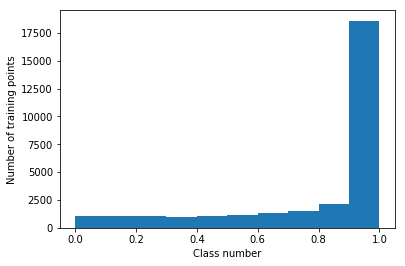

In [62]:
plt.hist(cross_margins)
plt.xlabel("Class number")
plt.ylabel("Number of training points")
plt.savefig("/Users/adhyyan/Desktop/pw_margin_cross", format = 'pdf')